## 1. Import all Package we need

In [1]:

import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
from zipfile import * # package for unzipping zip files

import requests # to download the meteostat dataset
import time # because we have just three calls per second we have to set a time.sleep

# Import the get_engine function from our sql_functions.
# We need this function to push the downloaded meteostat sets to PostgresSQL.
# Adjust the sql_functions.py connection 

from sql_functions import get_engine 
# We need this function to download the flight tables

from sql_functions import get_dataframe
# Import this package because all dates are series.
import datetime as dt 
from datetime import timedelta


import warnings
warnings.filterwarnings("ignore") 

# we need the schema to get a connection to the flight tables and meteostat postgresql.
schema = 'hh_analytics_22_3'
engine = get_engine()

# Das ist die neueste version !!!!!


In [2]:
# Library to plot
import matplotlib.pyplot as plt
from meteostat import Point, Daily # a meteostat package
import seaborn as sns

In [3]:
# To be able to pull the API key from the .env, we need to import and run the load_dotenv function from the dotenv module first.
from dotenv import load_dotenv
load_dotenv()

True

## 2. Import Meteostats and Transstats datasets

### Meteostats

In [4]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

!echo {path} >> .gitignore

mkdir: data/: File exists


In [5]:
# Get an API key at meteostat and check out the calls document
# Download the sets for all chosen faa's by station number
# copy the code which includes the start and end by stations and per day
# trying to download the hourly dataset would exceed and end up in a http 400
# the weather codes (coco) are just in the hourly datasets but aren't key parameters
schema = 'hh_analytics_22_3'
url = "https://meteostat.p.rapidapi.com/stations/daily"

Newark = {"station":"72502","start":"2021-08-01","end":"2021-09-30","tz":"Europe/Berlin","units":"EWR"} #newark
New_Orleans = {"station":"72231","start":"2021-08-01","end":"2021-09-30"} # new orleans
Fort_Lauderdale = {"station":"74783","start":"2021-08-01","end":"2021-09-30"} # fort lauderdale
Dulles = {"station":"72403","start":"2021-08-01","end":"2021-09-30"}  # dulles
New_York_City = {"station":"74486","start":"2021-08-01","end":"2021-09-30"} # jfk
Jackson = {"station":"72235","start":"2021-08-01","end":"2021-09-30"} # jackson
Atlanta = {"station":"72219","start":"2021-08-01","end":"2021-09-30"} # atlanta

headers = {
	"X-RapidAPI-Key": "22ef9ce8c8msh42fd8b2b6a62207p196a95jsn63ca8e76bb59",
	"X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=New_Orleans)
response2 = requests.request("GET", url, headers=headers, params=Fort_Lauderdale)
response3 = requests.request("GET", url, headers=headers, params=Dulles)
time.sleep(1)
response4 = requests.request("GET", url, headers=headers, params=New_York_City)
response5 = requests.request("GET", url, headers=headers, params=Jackson)
response6 = requests.request("GET", url, headers=headers, params=Atlanta)
time.sleep(1)
response7 = requests.request("GET", url, headers=headers, params=Newark)

#print(response.text) # msy/new orleans
#print(response2.text) # fll/fort lauderdale
#print(response3.text) # iad/dulles
#print(response4.text) # jfk/nyc
#print(response5.text) # jan/jackson
#print(response6.text) # atl/atlanta
#print(response7.text) # ewr/newark

In [6]:

meteostat_msy = response.json()
meteostat_fll = response2.json() #fll
meteostat_iad = response3.json() #iad
meteostat_jfk = response4.json()
meteostat_jan = response5.json()
meteostat_atl = response6.json()
meteostat_atl = response6.json()
meteostat_ewr = response7.json()

#print(meteostat_atl)

### Transstats

In [7]:
# function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month):
    
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    r = requests.get(f'{url}', verify=False)
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )

In [8]:
# function to extract the csv files inside the zip files

def extract_zip(year, month):
    
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    with ZipFile(path+zip_file, 'r') as zip_ref:
        zip_ref.extractall(path)
        csv_file =  zip_ref.namelist()[0]
        print(f'--> zip_file was succesfully extracted to: {csv_file}.' )

In [9]:
years_list = [2021] # list of years you want to look at (can of course also be a single year)
months_list = [8, 9] # list of months you want to look at (can of course also be a single month)

for year in years_list:
    for month in months_list:
        download_data(year, month)
        extract_zip(year, month)

--> zip_file with name: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2021_8.zip downloaded succesfully.
--> zip_file was succesfully extracted to: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2021_8.csv.
--> zip_file with name: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2021_9.zip downloaded succesfully.
--> zip_file was succesfully extracted to: On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2021_9.csv.


In [10]:
# define the name of the csv file you want to read in
csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2021_8.csv'
csv_file2 = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2021_9.csv'
# Read in your data
df = pd.read_csv(path+csv_file, low_memory = False)
df2 = pd.read_csv(path+csv_file2, low_memory = False)

In [11]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'ActualElapsedTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [12]:
# The columns in the database have different naming as in the source csv files. Lets get the names from the database
from sql_functions import get_engine

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('actual_elapsed_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [13]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names 

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'actual_elapsed_time',
 'distance',
 'cancelled',
 'diverted']

In [14]:
# Just in case the above fails here are the results
'''new_column_names_alternate = ['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 
                'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled', 'diverted' ]'''

"new_column_names_alternate = ['flight_date', 'dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', \n                'arr_delay', 'airline', 'tail_number', 'flight_number', 'origin', 'dest', 'air_time', 'actual_elapsed_time', 'distance', 'cancelled', 'diverted' ]"

In [15]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [16]:
df_clean = clean_airline_df(df)

In [17]:
def clean_airline_df2(df2):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df2_airline = df2.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df2_airline['FlightDate']= pd.to_datetime(df2_airline['FlightDate'], yearfirst=True)
    df2_airline['CRSArrTime']= pd.to_numeric(df2_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df2_airline['Cancelled']= pd.to_numeric(df2_airline['Cancelled'], downcast='integer')
    df2_airline['Diverted']= pd.to_numeric(df2_airline['Diverted'], downcast='integer')
    df2_airline['ActualElapsedTime']= pd.to_numeric(df2_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df2_airline.columns = new_column_names
    
    return df2_airline

In [18]:
df2_clean = clean_airline_df2(df2)

In [19]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [20]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport_df2(df2, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df2_out = df2.loc[(df2.origin.isin(airports)) | (df2.dest.isin(airports))]
    return df2_out

In [21]:
# Execute function, filtering for airports
airports=['JFK', 'MSY', 'ATL', 'JAN', 'IAD', 'FLL', 'EWR']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
214,2021-08-01,1500.0,1500,0.0,1625.0,1626,-1.0,OH,N517AE,5582,CLT,IAD,61.0,85.0,322.0,0,0
215,2021-08-02,1456.0,1500,-4.0,1646.0,1626,20.0,OH,N723PS,5582,CLT,IAD,50.0,110.0,322.0,0,0
216,2021-08-03,1605.0,1500,65.0,1724.0,1626,58.0,OH,N532EA,5582,CLT,IAD,52.0,79.0,322.0,0,0
217,2021-08-04,1456.0,1500,-4.0,1618.0,1626,-8.0,OH,N718PS,5582,CLT,IAD,50.0,82.0,322.0,0,0
218,2021-08-05,1456.0,1500,-4.0,1615.0,1626,-11.0,OH,N500AE,5582,CLT,IAD,49.0,79.0,322.0,0,0


In [22]:
# Execute function, filtering for airports
airports=['JFK', 'MSY', 'ATL', 'JAN', 'IAD', 'FLL', 'EWR']
if len(airports) > 0:
    df2_selected_airports = select_airport_df2(df2_clean, airports)
else:
    df2_selected_airports = df2_clean
    
df2_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
316,2021-09-01,849.0,859,-10.0,1008.0,1023,-15.0,OH,N509AE,5706,CLT,IAD,56.0,79.0,322.0,0,0
317,2021-09-02,853.0,859,-6.0,1017.0,1023,-6.0,OH,N520DC,5706,CLT,IAD,55.0,84.0,322.0,0,0
318,2021-09-03,855.0,859,-4.0,1021.0,1023,-2.0,OH,N502AE,5706,CLT,IAD,54.0,86.0,322.0,0,0
319,2021-09-04,853.0,859,-6.0,1003.0,1023,-20.0,OH,N540EG,5706,CLT,IAD,51.0,70.0,322.0,0,0
320,2021-09-06,859.0,859,0.0,1014.0,1023,-9.0,OH,N719PS,5706,CLT,IAD,50.0,75.0,322.0,0,0


In [23]:
# Merging our two df's
df_aug_sep_merge = pd.concat([df_selected_airports, df2_selected_airports])

In [24]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.

table_name = 'flights_ida_group3_aug_sep'

if engine!=None:
    try:
        df_aug_sep_merge.to_sql(name=table_name, 
                        con=engine, 
                        if_exists='replace',  
                        schema=schema, 
                        index=False, 
                        chunksize=5000, 
                        method='multi') 
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

# This code we used for all our airports 

The flights_ida_group3_aug_sep table was imported successfully.


In [25]:
# Just to be sure: Check if the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_aug_sep_merge.shape[0]

True

## 3. Flatten Jsons

In [26]:

df_meteostat_msy = pd.json_normalize(meteostat_msy,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_msy.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,29.2,25.6,36.1,0.0,None,313.0,6.8,None,1016.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_meteostat_fll = pd.json_normalize(meteostat_fll,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_fll.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,29.3,25.6,32.8,28.4,0.0,148.0,10.4,None,1018.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_meteostat_iad = pd.json_normalize(meteostat_iad,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_iad.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,22.7,18.3,26.1,16.5,0.0,208.0,6.1,None,1011.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_meteostat_jfk = pd.json_normalize(meteostat_jfk,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_jfk.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,21.5,18.3,25.0,1.0,0.0,168.0,14.8,None,1012.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_meteostat_jan = pd.json_normalize(meteostat_jan,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_jan.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,29.2,25.0,35.6,0.0,0.0,271.0,7.2,None,1015.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_meteostat_atl = pd.json_normalize(meteostat_atl,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_atl.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,27.4,23.3,32.2,0.3,0.0,282.0,16.2,None,1014.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_meteostat_ewr = pd.json_normalize(meteostat_ewr,
                                record_path="data",
                                  sep="_",                                   
                                  meta=["date",
                                  "tavg",
                                  "tmin",
                                  "tmax",
                                  "prcp",
                                  "snow",
                                  "wspd",
                                  "wpgt",
                                  "pres",
                                  "tsun"], 
                                record_prefix="daily_",
                                errors='ignore')
df_meteostat_ewr.head(1)

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,22.7,18.3,26.7,3.3,0.0,178.0,8.6,None,1012.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Connect Meteotables to PostgreSQL

In [33]:
# Specify which table within your database you want to push your data to PostgreSQL.

table_name = 'msy_meteo_ida_group3'
engine = get_engine()
if engine!=None:
    try:
        df_meteostat_msy.to_sql(name=table_name, 
                        con=engine, 
                        if_exists='replace', 
                        schema=schema, 
                        index=False, 
                        chunksize=5000, 
                        method='multi') 
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The msy_meteo_ida_group3 table was imported successfully.


In [34]:
table_name = 'fll_meteo_ida_group3'
if engine!=None:
    try:
        df_meteostat_fll.to_sql(name=table_name,
                        con=engine,
                        if_exists='replace', 
                        schema=schema,
                        index=False, 
                        chunksize=5000,
                        method='multi') 
        print(f"The {table_name} table was imported successfully.")
   
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The fll_meteo_ida_group3 table was imported successfully.


In [35]:
table_name = 'iad_meteo_ida_group3'
engine = get_engine()
if engine!=None:
    try:
        df_meteostat_iad.to_sql(name=table_name,
                        con=engine, 
                        if_exists='replace',
                        schema=schema,
                        index=False, 
                        chunksize=5000, 
                        method='multi') 
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The iad_meteo_ida_group3 table was imported successfully.


In [36]:
table_name = 'jfk_meteo_ida_group3'
engine = get_engine()
if engine!=None:
    try:
        df_meteostat_jfk.to_sql(name=table_name, 
                        con=engine, 
                        if_exists='replace',
                        schema=schema, 
                        index=False, 
                        chunksize=5000,
                        method='multi')
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The jfk_meteo_ida_group3 table was imported successfully.


In [37]:
table_name = 'jan_meteo_ida_group3'
engine = get_engine()
if engine!=None:
    try:
        df_meteostat_jan.to_sql(name=table_name, 
                        schema=schema, 
                        index=False, 
                        if_exists='replace',
                        con=engine, 
                        chunksize=5000,
                        method='multi')
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The jan_meteo_ida_group3 table was imported successfully.


In [38]:
table_name = 'atl_meteo_ida_group3'
engine = get_engine()
if engine!=None:
    try:
        df_meteostat_atl.to_sql(name=table_name, 
                        con=engine, 
                        if_exists='replace',
                        schema=schema, 
                        index=False, 
                        chunksize=5000,
                        method='multi')
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The atl_meteo_ida_group3 table was imported successfully.


In [39]:
table_name = 'ewr_meteo_ida_group3'
engine = get_engine()
if engine!=None:
    try:
        df_meteostat_ewr.to_sql(name=table_name, 
                        con=engine, 
                        if_exists='replace',
                        schema=schema, 
                        index=False, 
                        chunksize=5000,
                        method='multi')
        print(f"The {table_name} table was imported successfully.")
    
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The ewr_meteo_ida_group3 table was imported successfully.


In [40]:
#import the 7 different weather station tables, one for each airport 

atl_weather = get_dataframe(f'SELECT * FROM {schema}.atl_meteo_ida_group3;')
fll_weather = get_dataframe(f'SELECT * FROM {schema}.fll_meteo_ida_group3;')
iad_weather = get_dataframe(f'SELECT * FROM {schema}.iad_meteo_ida_group3;')
jan_weather = get_dataframe(f'SELECT * FROM {schema}.jan_meteo_ida_group3;')
jfk_weather = get_dataframe(f'SELECT * FROM {schema}.jfk_meteo_ida_group3;')
msy_weather = get_dataframe(f'SELECT * FROM {schema}.msy_meteo_ida_group3;')
ewr_weather = get_dataframe(f'SELECT * FROM {schema}.ewr_meteo_ida_group3;')

## 5. Work in SQL 

### - Create copies of meteostat tables
### - Drop Columns
### - Add new columns and define a primary key:
### - First column: Serial Id as primary key.
### - Second column: Faa for all stations 61x times because of 61 daily_dates.

# New Data Tables 

In [41]:
# The two new columns which were created in PostgreSQL: stations and id 

import sql_functions as sf 

msy_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.msy_schmarn') 
msy_schmarn.info()


msy_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.msy_meteo_ida_group3_schmarn')
msy_met_schmarn.info()


concat_msy = pd.concat([msy_schmarn, msy_met_schmarn], axis=1)
concat_msy.head(5)
concat_msy = concat_msy[:-1]

concat_msy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   station  61 non-null     object
 1   id       61 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   daily_date  61 non-null     object 
 1   daily_tavg  61 non-null     float64
 2   daily_tmin  61 non-null     float64
 3   daily_tmax  61 non-null     float64
 4   daily_prcp  60 non-null     float64
 5   daily_wdir  61 non-null     float64
 6   daily_wspd  61 non-null     float64
 7   daily_pres  61 non-null     float64
dtypes: float64(7), object(1)
memory usage: 4.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 10 columns):
 #   Column      Non-Null Count  

In [42]:
atl_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.atl_schmarn')
atl_schmarn.head(5)

atl_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.atl_meteo_ida_group3_schmarn')
atl_met_schmarn.head(4)

concat_atl = pd.concat([atl_schmarn, atl_met_schmarn], axis=1)
concat_atl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     61 non-null     object 
 1   id          61 non-null     int64  
 2   daily_date  61 non-null     object 
 3   daily_tavg  61 non-null     float64
 4   daily_tmin  61 non-null     float64
 5   daily_tmax  61 non-null     float64
 6   daily_prcp  61 non-null     float64
 7   daily_snow  61 non-null     float64
 8   daily_wdir  61 non-null     float64
 9   daily_wspd  61 non-null     float64
 10  daily_pres  61 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.4+ KB


In [43]:
jfk_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.jfk_schmarn')
jfk_schmarn.head(5)

jfk_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.jfk_meteo_ida_group3_schmarn')
jfk_met_schmarn.head(4)

concat_jfk = pd.concat([jfk_schmarn, jfk_met_schmarn], axis=1)
concat_jfk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     61 non-null     object 
 1   id          61 non-null     int64  
 2   daily_date  61 non-null     object 
 3   daily_tavg  61 non-null     float64
 4   daily_tmin  61 non-null     float64
 5   daily_tmax  61 non-null     float64
 6   daily_prcp  61 non-null     float64
 7   daily_snow  61 non-null     float64
 8   daily_wdir  61 non-null     float64
 9   daily_wspd  61 non-null     float64
 10  daily_pres  61 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.4+ KB


In [44]:
jan_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.jan_schmarn')
jan_schmarn.head(5)

jan_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.jan_meteo_ida_group3_schmarn')
jan_met_schmarn.head(4)

concat_jan = pd.concat([jan_schmarn, jan_met_schmarn], axis=1)
concat_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     61 non-null     object 
 1   id          61 non-null     int64  
 2   daily_date  61 non-null     object 
 3   daily_tavg  61 non-null     float64
 4   daily_tmin  61 non-null     float64
 5   daily_tmax  61 non-null     float64
 6   daily_prcp  61 non-null     float64
 7   daily_snow  61 non-null     float64
 8   daily_wdir  61 non-null     float64
 9   daily_wspd  61 non-null     float64
 10  daily_pres  61 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.4+ KB


In [45]:
iad_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.iad_schmarn')
iad_schmarn.head(5)

iad_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.iad_meteo_ida_group3_schmarn')
iad_met_schmarn.head(4)

concat_iad = pd.concat([iad_schmarn, iad_met_schmarn], axis=1)
concat_iad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     61 non-null     object 
 1   id          61 non-null     int64  
 2   daily_date  61 non-null     object 
 3   daily_tavg  61 non-null     float64
 4   daily_tmin  61 non-null     float64
 5   daily_tmax  61 non-null     float64
 6   daily_prcp  61 non-null     float64
 7   daily_snow  61 non-null     float64
 8   daily_wdir  61 non-null     float64
 9   daily_wspd  61 non-null     float64
 10  daily_pres  61 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.4+ KB


In [46]:
fll_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.fll_schmarn')
fll_schmarn.head(5)

fll_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.fll_meteo_ida_group3_schmarn')
fll_met_schmarn.head(4)

concat_fll = pd.concat([fll_schmarn, fll_met_schmarn], axis=1)
concat_fll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     61 non-null     object 
 1   id          61 non-null     int64  
 2   daily_date  61 non-null     object 
 3   daily_tavg  61 non-null     float64
 4   daily_tmin  61 non-null     float64
 5   daily_tmax  61 non-null     float64
 6   daily_prcp  60 non-null     float64
 7   daily_snow  43 non-null     float64
 8   daily_wdir  61 non-null     float64
 9   daily_wspd  61 non-null     float64
 10  daily_pres  61 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.4+ KB


In [47]:
ewr_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.ewr_schmarn')
ewr_schmarn.head(5)

ewr_met_schmarn= sf.get_dataframe(f'SELECT * FROM {schema}.ewr_meteo_ida_group3_schmarn')
ewr_met_schmarn.head(4)

concat_ewr = pd.concat([ewr_schmarn, ewr_met_schmarn], axis=1)
concat_ewr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station     61 non-null     object 
 1   id          61 non-null     int64  
 2   daily_date  61 non-null     object 
 3   daily_tavg  61 non-null     float64
 4   daily_tmin  61 non-null     float64
 5   daily_tmax  61 non-null     float64
 6   daily_prcp  61 non-null     float64
 7   daily_wdir  61 non-null     float64
 8   daily_wspd  61 non-null     float64
 9   daily_pres  61 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.9+ KB


In [48]:
# remove null values only for fll and msy.
concat_fll['daily_snow'].fillna(concat_fll['daily_snow'].value_counts().index[0], inplace= True)
concat_fll['daily_prcp'].fillna(concat_fll['daily_prcp'].value_counts().index[0], inplace= True)
concat_msy['station'].fillna(concat_msy['station'].value_counts().index[0], inplace= True)
concat_msy['id'].fillna(concat_msy['id'].value_counts().index[0], inplace= True)
concat_msy['daily_date'].fillna(concat_msy['daily_date'].value_counts().index[0], inplace= True)
concat_msy['daily_tavg'].fillna(concat_msy['daily_tavg'].value_counts().index[0], inplace= True)
concat_msy['daily_tmin'].fillna(concat_msy['daily_tmin'].value_counts().index[0], inplace= True)
concat_msy['daily_tmax'].fillna(concat_msy['daily_tmax'].value_counts().index[0], inplace= True)
concat_msy['daily_prcp'].fillna(concat_msy['daily_prcp'].value_counts().index[0], inplace= True)
concat_msy['daily_wdir'].fillna(concat_msy['daily_wdir'].value_counts().index[0], inplace= True)
concat_msy['daily_wspd'].fillna(concat_msy['daily_wspd'].value_counts().index[0], inplace= True)
concat_msy['daily_pres'].fillna(concat_msy['daily_pres'].value_counts().index[0], inplace= True)

In [49]:
concat_fll['daily_date']= pd.to_datetime(concat_fll['daily_date'])
concat_msy['daily_date']= pd.to_datetime(concat_msy['daily_date'])
concat_jfk['daily_date']= pd.to_datetime(concat_jfk['daily_date'])
concat_iad['daily_date']= pd.to_datetime(concat_iad['daily_date'])
concat_atl['daily_date']= pd.to_datetime(concat_atl['daily_date'])
concat_jan['daily_date']= pd.to_datetime(concat_jan['daily_date'])
concat_ewr['daily_date']= pd.to_datetime(concat_ewr['daily_date'])

In [50]:
#import the 7 different weather station tables, one for each airport 

atl_weather = get_dataframe(f'SELECT * FROM {schema}.atl_meteo_ida_group3;')
fll_weather = get_dataframe(f'SELECT * FROM {schema}.fll_meteo_ida_group3;')
iad_weather = get_dataframe(f'SELECT * FROM {schema}.iad_meteo_ida_group3;')
jan_weather = get_dataframe(f'SELECT * FROM {schema}.jan_meteo_ida_group3;')
jfk_weather = get_dataframe(f'SELECT * FROM {schema}.jfk_meteo_ida_group3;')
msy_weather = get_dataframe(f'SELECT * FROM {schema}.msy_meteo_ida_group3;')
ewr_weather = get_dataframe(f'SELECT * FROM {schema}.ewr_meteo_ida_group3;')

In [51]:
flights_ida = get_dataframe(f'SELECT * FROM {schema}.flights_lat_lon_ida_group3;')

flights_atl = flights_ida[flights_ida['origin'] == 'ATL']
flights_atl_grp = flights_atl.groupby(['flight_date']).mean().reset_index()
flights_fll = flights_ida[flights_ida['origin'] == 'FLL']
flights_fll_grp = flights_fll.groupby(['flight_date']).mean().reset_index()
flights_iad = flights_ida[flights_ida['origin'] == 'IAD']
flights_iad_grp = flights_iad.groupby(['flight_date']).mean().reset_index()
flights_jan = flights_ida[flights_ida['origin'] == 'JAN']
flights_jan_grp = flights_jan.groupby(['flight_date']).mean().reset_index()
flights_jfk = flights_ida[flights_ida['origin'] == 'JFK']
flights_jfk_grp = flights_jfk.groupby(['flight_date']).mean().reset_index()
flights_msy = flights_ida[flights_ida['origin'] == 'MSY']
flights_msy_grp = flights_msy.groupby(['flight_date']).mean().reset_index()
flights_ewr = flights_ida[flights_ida['origin'] == 'EWR']
flights_ewr_grp = flights_ewr.groupby(['flight_date']).mean().reset_index()



In [52]:
# create merged and cleaned data sets for all 7 airports
msy_merged = pd.concat([flights_msy_grp, msy_weather], axis=1)
msy_cleaned = msy_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])
atl_merged = pd.concat([flights_atl_grp, atl_weather], axis=1)
atl_cleaned = atl_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])
fll_merged = pd.concat([flights_fll_grp, fll_weather], axis=1)
fll_cleaned = fll_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])
iad_merged = pd.concat([flights_iad_grp, iad_weather], axis=1)
iad_cleaned = iad_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])
jan_merged = pd.concat([flights_jan_grp, jan_weather], axis=1)
jan_cleaned = jan_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])
jfk_merged = pd.concat([flights_jfk_grp, jfk_weather], axis=1)
jfk_cleaned = jfk_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])
ewr_merged = pd.concat([flights_ewr_grp, ewr_weather], axis=1)
#ewr_cleaned = ewr_merged.drop(columns=['date', 'tavg', 'tmin', 'tmax', 'prcp',
       #'snow', 'wspd', 'wpgt', 'pres', 'tsun','daily_snow','daily_wdir', 'distance','actual_elapsed_time', 'flight_number'])

In [53]:
ewr_merged.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,flight_number,air_time,actual_elapsed_time,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
0,2021-08-01,1192.848485,1241.222222,27.212121,1375.787879,1424.944444,27.484848,1675.861111,128.818182,157.484848,...,None,None,None,None,None,None,None,None,None,None
1,2021-08-02,1238.406250,1237.297297,16.625000,1410.968750,1421.783784,9.516129,1573.540541,123.129032,149.258065,...,None,None,None,None,None,None,None,None,None,None
2,2021-08-03,1238.678571,1248.970588,8.750000,1506.785714,1495.882353,12.846154,1533.382353,129.192308,154.192308,...,None,None,None,None,None,None,None,None,None,None
3,2021-08-04,1244.500000,1250.972222,9.766667,1490.433333,1431.583333,7.833333,1530.916667,124.900000,151.933333,...,None,None,None,None,None,None,None,None,None,None
4,2021-08-05,1301.032258,1242.805556,32.516129,1456.741935,1424.388889,24.193548,1554.027778,122.032258,146.032258,...,None,None,None,None,None,None,None,None,None,None


In [54]:
ewr_weather.tail()

,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_wpgt,daily_pres,...,date,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres,tsun
56,2021-09-26,20.6,17.2,24.4,0.0,0.0,272.0,18.7,None,1012.4,...,None,None,None,None,None,None,None,None,None,None
57,2021-09-27,21.1,14.4,28.3,0.0,0.0,225.0,21.2,None,1013.7,...,None,None,None,None,None,None,None,None,None,None
58,2021-09-28,21.5,16.7,24.4,4.6,0.0,249.0,15.5,None,1010.5,...,None,None,None,None,None,None,None,None,None,None
59,2021-09-29,18.2,12.8,22.2,0.0,0.0,330.0,16.9,None,1015.0,...,None,None,None,None,None,None,None,None,None,None
60,2021-09-30,18.0,13.9,21.1,0.0,0.0,327.0,16.6,None,1018.9,...,None,None,None,None,None,None,None,None,None,None


In [55]:
ewr_weather_grp = ewr_weather.groupby(['daily_date']).mean().reset_index()
ewr_weather_grp.describe()

,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_snow,daily_wdir,daily_wspd,daily_pres
count,61.000000,61.000000,61.000000,61.000000,61.0,61.000000,61.000000,61.000000
mean,24.545902,20.145902,29.037705,7.368852,0.0,189.754098,13.644262,1016.231148
std,2.975263,3.378045,3.632362,28.969337,0.0,104.340413,4.436535,4.666174
min,18.000000,12.800000,21.100000,0.000000,0.0,0.000000,5.400000,1006.600000
25%,22.700000,17.200000,26.700000,0.000000,0.0,97.000000,10.400000,1012.600000
50%,24.300000,21.100000,28.300000,0.000000,0.0,215.000000,13.300000,1016.500000
75%,26.200000,22.800000,31.100000,0.800000,0.0,278.000000,16.600000,1019.600000
max,31.500000,25.600000,37.200000,213.600000,0.0,343.000000,24.500000,1026.500000


# Time to plot:

In [56]:
import seaborn as sns

# dataplot=sns.heatmap(msy_cleaned.corr())
  
# # displaying heatmap
# plt.show()

In [57]:
flights_msy = flights_ida[flights_ida['origin'] == 'MSY']
flights_msy_grp = flights_msy.groupby(['flight_date']).mean().reset_index()

In [58]:
msy_merged = pd.concat([concat_msy, flights_msy_grp], axis=1)
msy_merged.head()

,station,id,daily_date,daily_tavg,daily_tmin,daily_tmax,daily_prcp,daily_wdir,daily_wspd,daily_pres,...,sched_arr_time,arr_delay,flight_number,air_time,actual_elapsed_time,distance,cancelled,diverted,lat,lon
0,MSY,1.0,2021-08-01,29.2,25.6,36.1,0.0,313.0,6.8,1016.5,...,1496.709402,28.894231,2698.145299,103.201923,127.413462,734.683761,0.085470,0.025641,29.993401,-90.258003
1,MSY,2.0,2021-08-02,27.7,25.6,31.7,25.4,288.0,4.3,1015.6,...,1511.700787,31.247788,1937.377953,102.300885,125.920354,735.984252,0.102362,0.007874,29.993401,-90.258003
2,MSY,3.0,2021-08-03,27.2,24.4,31.7,21.1,298.0,5.8,1014.1,...,1490.312500,8.106796,2847.258929,101.883495,123.854369,730.026786,0.071429,0.008929,29.993401,-90.258003
3,MSY,4.0,2021-08-04,28.4,26.1,33.3,0.3,17.0,11.2,1014.7,...,1493.701754,0.518182,2813.763158,100.663636,122.709091,734.271930,0.035088,0.000000,29.993401,-90.258003
4,MSY,5.0,2021-08-05,29.1,22.8,32.8,0.0,354.0,5.8,1017.4,...,1502.360656,3.456140,1987.967213,100.508772,121.929825,727.180328,0.065574,0.000000,29.993401,-90.258003


In [59]:
# flights_grp = flights_ida.groupby(['flight_date']).mean().reset_index()

# plt.figure(figsize=(20,9))
# plt.xticks(rotation=45)
# plt.plot(msy_merged['daily_date'], msy_merged['cancelled']);
# plt.figure(figsize=(20,9))
# fig.tight_layout(h_pad=-2)
# plt.xticks(rotation=45)
# plt.plot(msy_merged['daily_date'], msy_merged['daily_prcp']);

# Our Hypotheses:
1. Can we see Hurricane Ida within the weather datasets?
2. Can we see Hurricane Ida within the flights datasets?
3. Can we see a correlation between them?

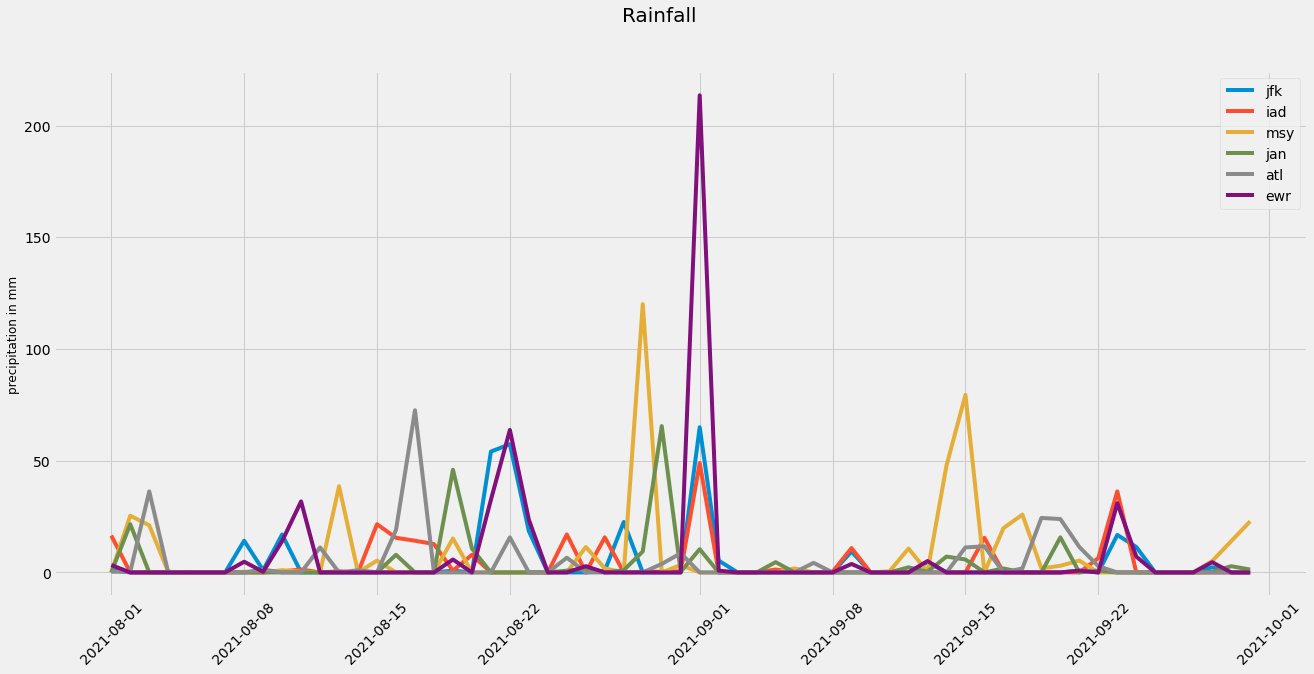

In [70]:
# can we see hurricane ida within the weather datasets?

plt.style.use('fivethirtyeight')

# Set figure size
plt.figure(figsize=(20,9))

# We will again use our grouped dataframe 
#plt.plot(concat_fll['daily_date'], concat_fll['daily_prcp']); #blue
plt.plot(concat_jfk['daily_date'], concat_jfk['daily_prcp']); #red
plt.plot(concat_iad['daily_date'], concat_iad['daily_prcp']); #violet
plt.plot(concat_msy['daily_date'], concat_msy['daily_prcp']); #green
plt.plot(concat_jan['daily_date'], concat_jan['daily_prcp']); #orange
plt.plot(concat_atl['daily_date'], concat_atl['daily_prcp']); #pink
plt.plot(concat_ewr['daily_date'], concat_ewr['daily_prcp']); #

# Label your axes
plt.ylabel("precipitation in mm", fontsize = 12)
plt.xticks(rotation=45)
# Set title
plt.suptitle("Rainfall", fontsize = 20)
plt.legend(["jfk", "iad", "msy", "jan","atl","ewr"], loc ="upper right")
# Show graphic
plt.show()

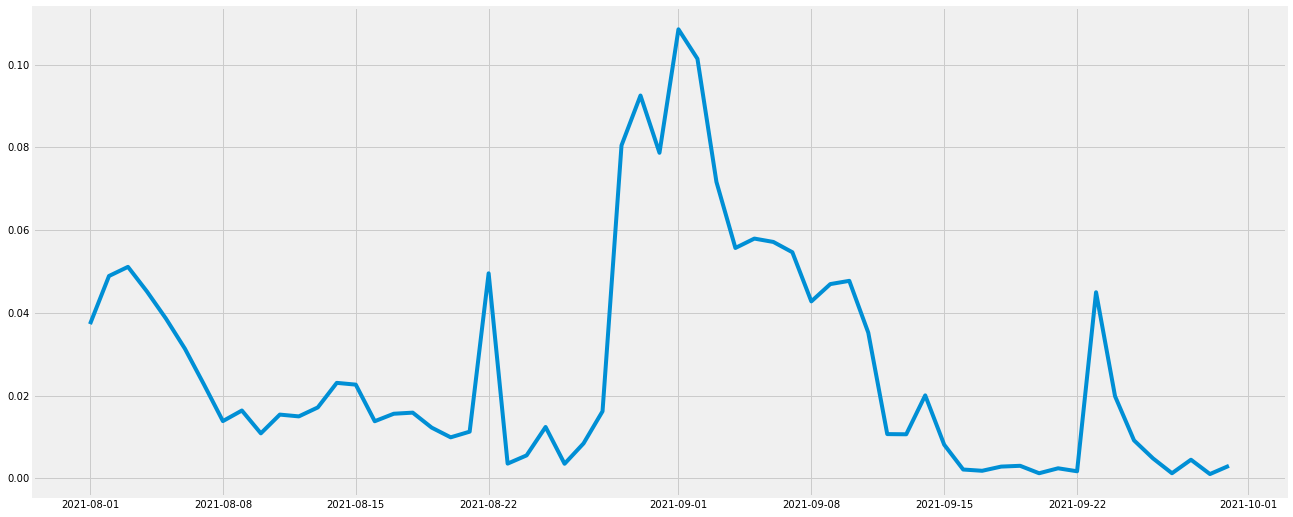

<Figure size 1440x648 with 0 Axes>

In [61]:
# can we see hurricane ida within the flights datasets?
# total flights cancellation 

flights_grp = flights_ida.groupby(['flight_date']).mean().reset_index()

plt.figure(figsize=(20,9));
plt.plot(flights_grp['flight_date'], flights_grp['cancelled']);
plt.figure(figsize=(20,9));

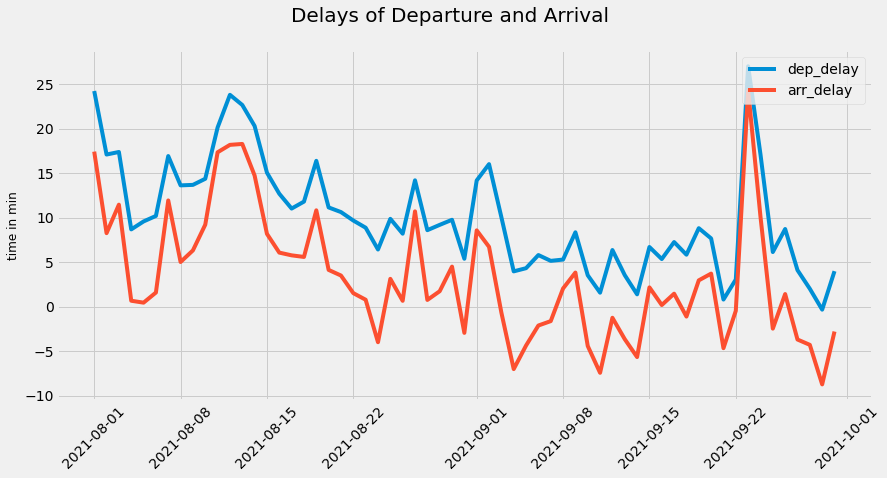

In [62]:
# total delays of departures and arrivals
# the same plot for the flights_grp
# Set figure size

flights_grp = flights_ida.groupby(['flight_date']).mean().reset_index()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(13, 6))

# We will again use our grouped dataframe 
plt.plot(flights_grp['flight_date'], flights_grp['dep_delay']); #blue
plt.plot(flights_grp['flight_date'], flights_grp['arr_delay']); #red
# Label your axes
plt.ylabel("time in min", fontsize = 12)
plt.xticks(rotation=45)
# Set title
plt.suptitle("Delays of Departure and Arrival", fontsize = 20)
plt.legend(["dep_delay", "arr_delay"], loc ="upper right");

# Detailed Analysis:
Let's have a closer look at 
* New Orleans msy
* New York jfk
* Newark ewr

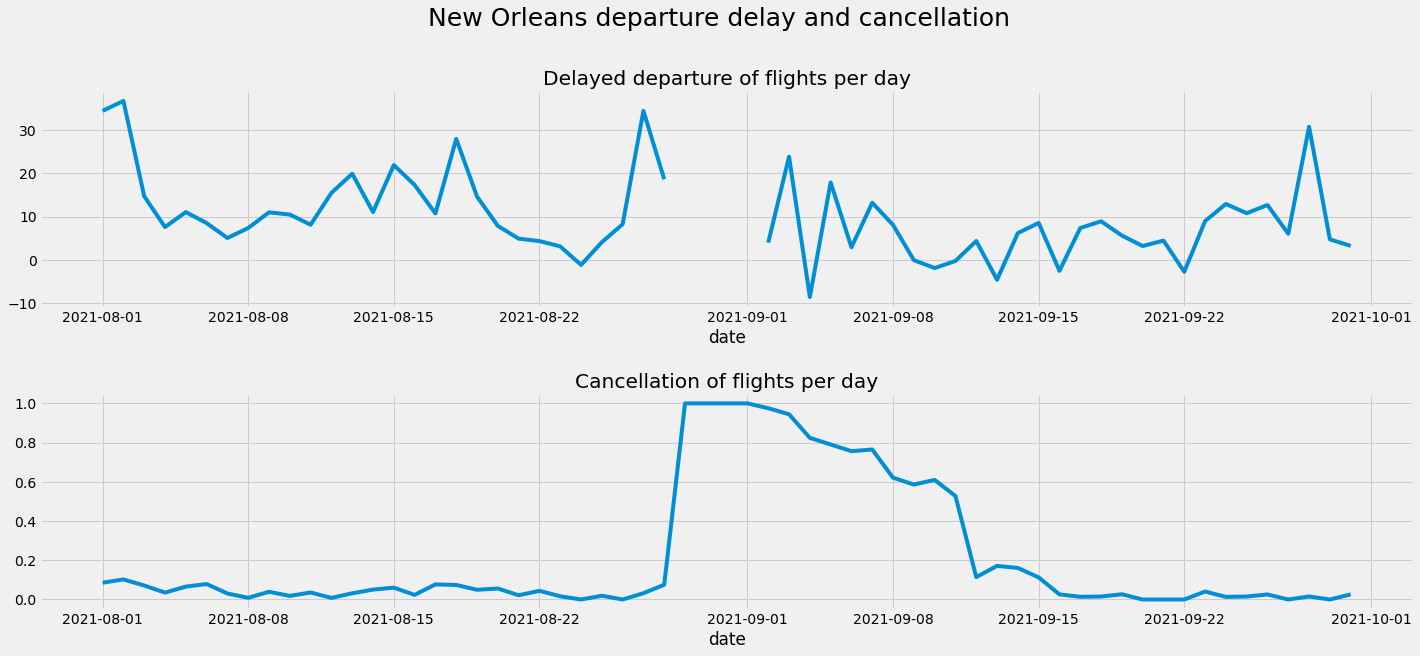

In [63]:
# New Orleans departure delay and cancellation

x = np.linspace(0, 10, 100)
fig, ax = plt.subplots(2,figsize=(20,9)) # is equiveltent to (2,1)
plt.suptitle('New Orleans departure delay and cancellation', fontsize=25)
fig.tight_layout(h_pad=5) # Creates space between axes for subplot titles. Try commenting out to see default behavior
plt.subplots_adjust(top=0.85) # Creates space between figure title and 1st subplot title.

ax[0].plot(msy_merged.flight_date,msy_merged.dep_delay)
ax[1].plot(flights_msy_grp.flight_date,flights_msy_grp.cancelled)

ax[0].set_xlabel('date')
ax[1].set_title('Cancellation of flights per day')

ax[0].set_title('Delayed departure of flights per day')
ax[1].set_xlabel('date');

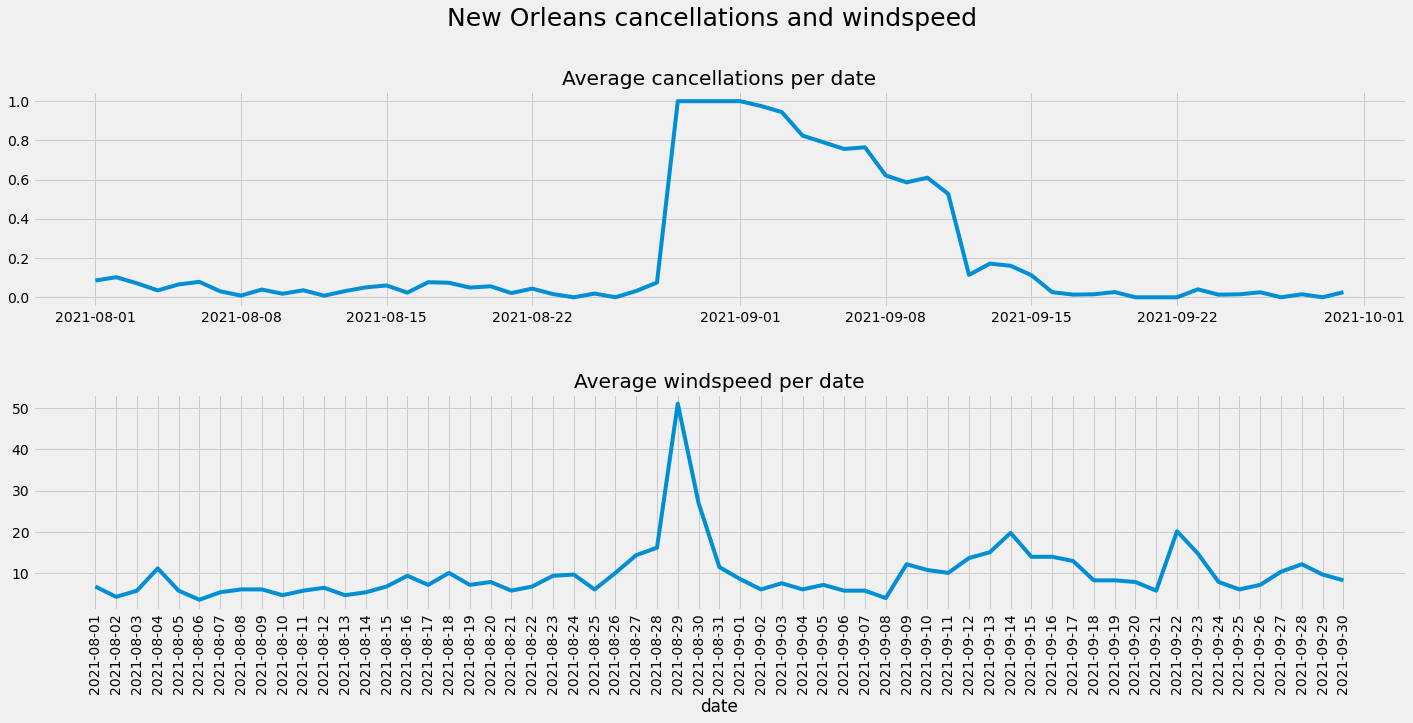

In [64]:
# As we could see, there all delays let to cancellations for 3 days. the airport was simply shut down in new orleans. 
# windspeed was one major reason but just as well rainfall had caused to cancellations in new orleans for almost 3 days.

x = np.linspace(0, 10, 100)
fig, ax = plt.subplots(2,figsize=(20,9)) # is equiveltent to (2,1)
plt.suptitle('New Orleans cancellations and windspeed', fontsize=25)
fig.tight_layout(h_pad=5) # Creates space between axes for subplot titles. Try commenting out to see default behavior
plt.subplots_adjust(top=0.85) # Creates space between figure title and 1st subplot title.

ax[0].plot(flights_msy_grp.flight_date, flights_msy_grp.cancelled)
ax[1].plot(msy_weather.daily_date, msy_weather.daily_wspd)

ax[0].set_title('Average cancellations per date')
ax[1].set_xlabel('date')
plt.xticks(rotation=90)

ax[1].set_title('Average windspeed per date');

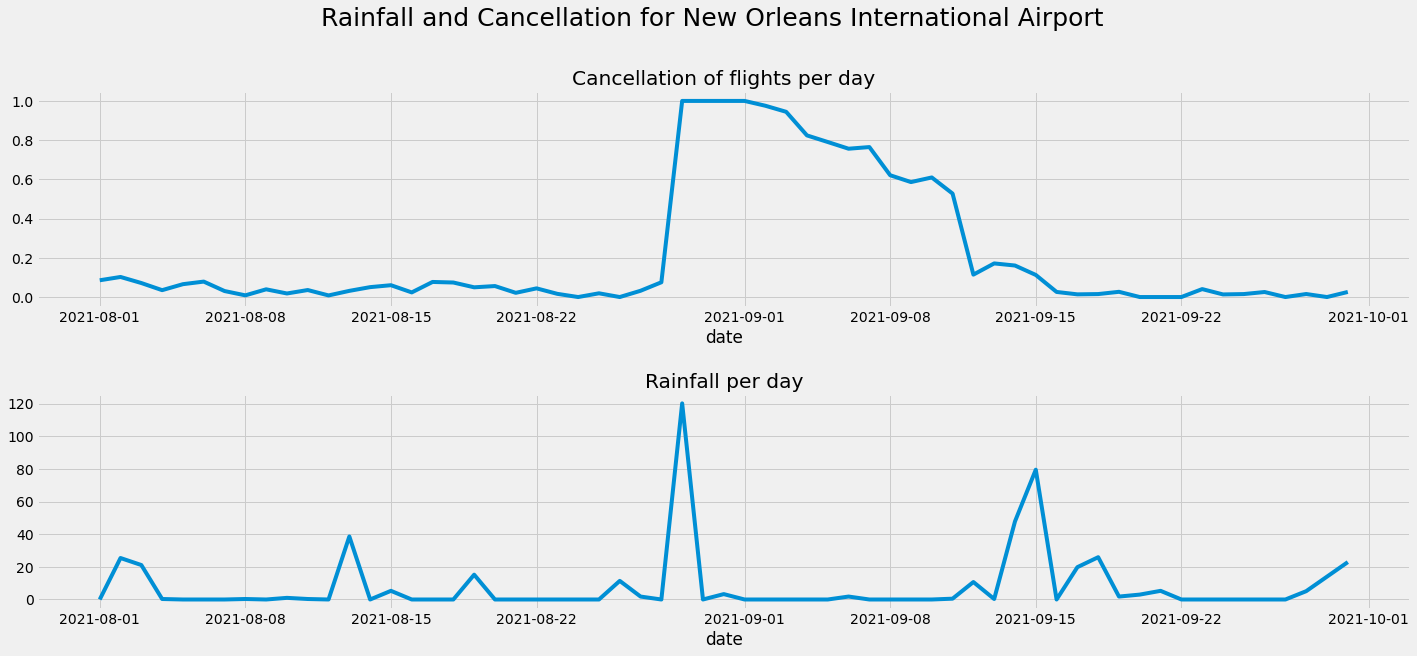

In [65]:
x = np.linspace(0, 10, 100)
fig, ax = plt.subplots(2,figsize=(20,9)) # is equiveltent to (2,1)
plt.suptitle('Rainfall and Cancellation for New Orleans International Airport ', fontsize=25)
fig.tight_layout(h_pad=5) # Creates space between axes for subplot titles. Try commenting out to see default behavior
plt.subplots_adjust(top=0.85) # Creates space between figure title and 1st subplot title.

ax[0].plot(msy_merged.flight_date,msy_merged.cancelled)
ax[1].plot(concat_msy.daily_date, concat_msy.daily_prcp)

ax[1].set_title('Rainfall per day')
ax[0].set_xlabel('date')

ax[0].set_title('Cancellation of flights per day')
ax[1].set_xlabel('date');

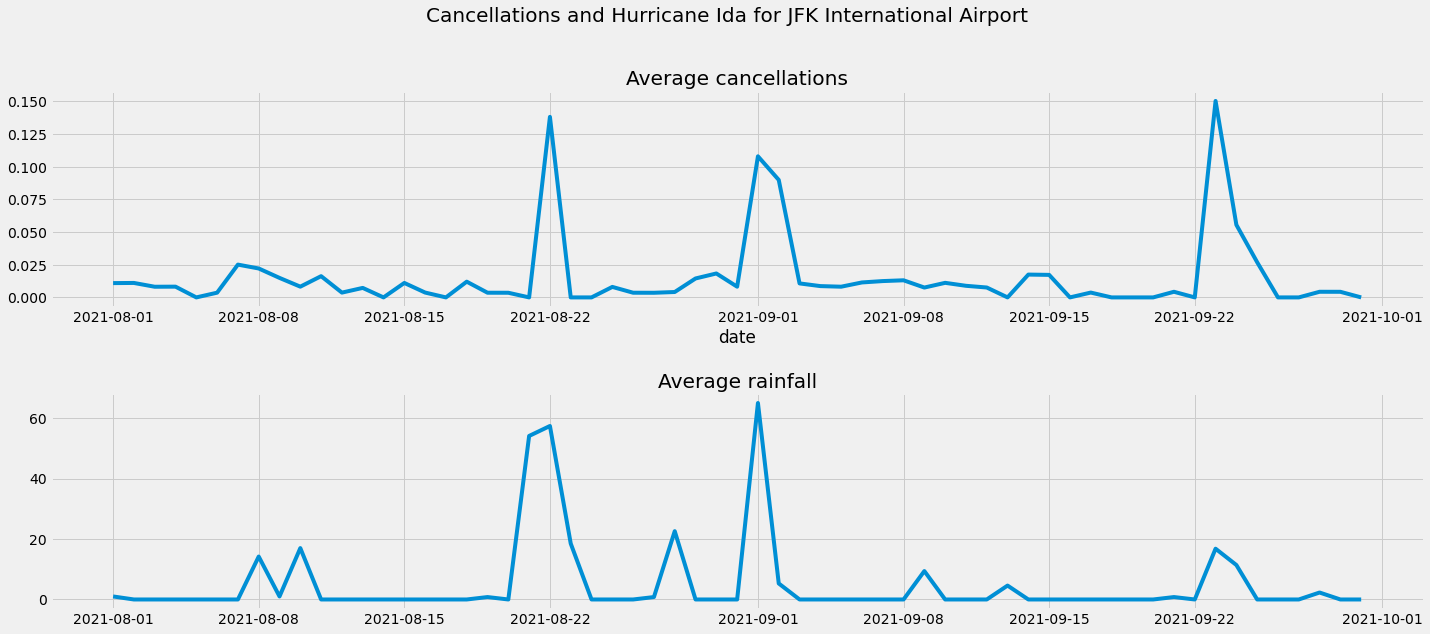

In [66]:
# huge impact of windspeeds on cancellations, not quite as bad as new orleans but our second highest impacted airport in terms of cancellations
x = np.linspace(0, 10, 100)
fig, ax = plt.subplots(2,figsize=(20,9)) # is equiveltent to (2,1)
plt.suptitle('Cancellations and Hurricane Ida for JFK International Airport ', fontsize=20)
fig.tight_layout(h_pad=5) # Creates space between axes for subplot titles. Try commenting out to see default behavior
plt.subplots_adjust(top=0.85) # Creates space between figure title and 1st subplot title.

ax[0].plot(jfk_cleaned.flight_date, jfk_cleaned.cancelled)

ax[1].plot(jfk_cleaned.flight_date, jfk_cleaned.daily_prcp)

ax[0].set_title('Average cancellations')
ax[0].set_xlabel('date')


ax[1].set_title('Average rainfall');

In [67]:
# interestingly in jfk were hardly cancellations compared to newark which lies geographically less than 50km away.
# flights_jfk_grp_sum = flights_jfk.groupby(['flight_date']).sum().reset_index()

# # checking the data for sum of cancellations

# x = np.linspace(0, 10, 100)
# fig, ax = plt.subplots(2,figsize=(14,8)) # is equiveltent to (2,1)
# plt.suptitle('New York cancellation of flights and windspeed', fontsize=20)
# fig.tight_layout(h_pad=-2) # Creates space between axes for subplot titles. Try commenting out to see default behavior
# plt.subplots_adjust(top=0.85) # Creates space between figure title and 1st subplot title.

# ax[0].plot(flights_jfk_grp_sum.flight_date, flights_jfk_grp_sum.cancelled)

# ax[1].plot(jfk_weather.daily_date, jfk_weather.daily_prcp)

# ax[0].set_title('Sum total cancellations by date')
# ax[1].set_xlabel('date')
# plt.xticks(rotation=90)

# ax[1].set_title('Average Windspeed by date');

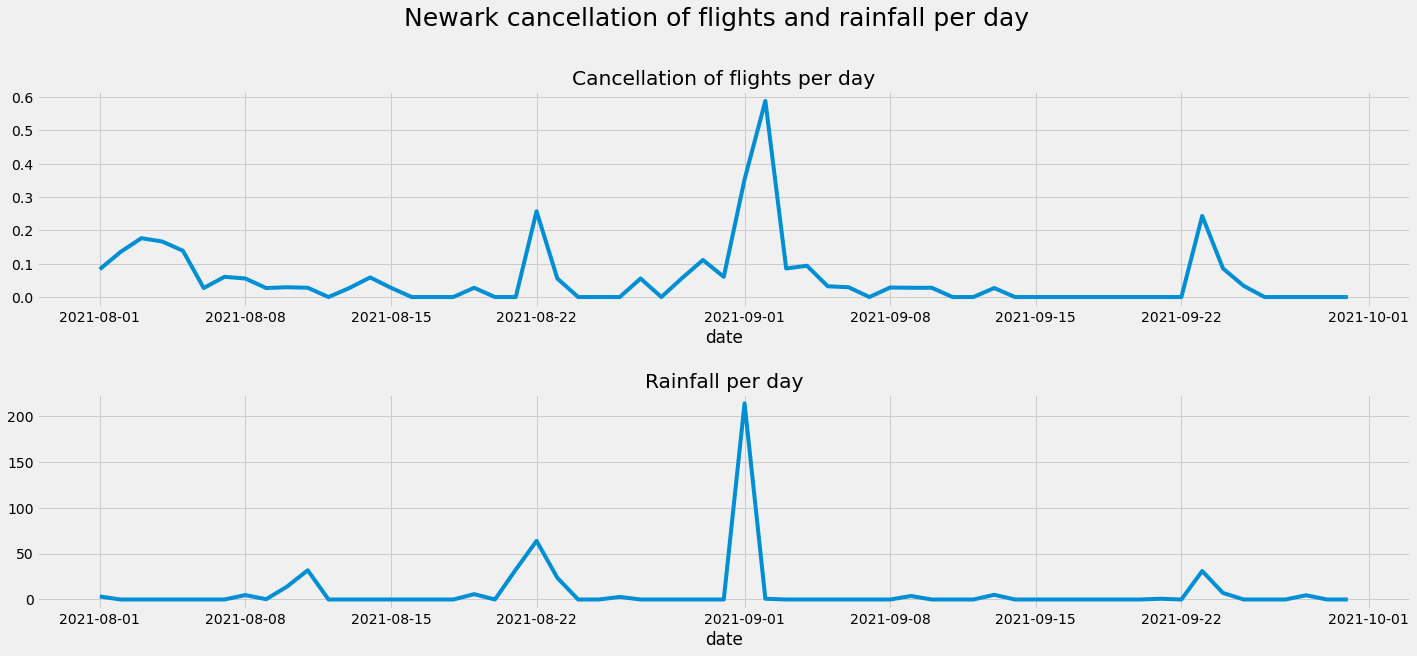

In [68]:
# a very interesing and contrasting picture can be drawn in newark compared to jfk:
# cancellation were at almost 60% and newark airport had severe flooding issues with a rainfall of over 200 mm precipitation. 

x = np.linspace(0, 10, 100)
fig, ax = plt.subplots(2,figsize=(20,9)) # is equiveltent to (2,1)
plt.suptitle('Newark cancellation of flights and rainfall per day', fontsize=25)
fig.tight_layout(h_pad=5) # Creates space between axes for subplot titles. Try commenting out to see default behavior
plt.subplots_adjust(top=0.85) # Creates space between figure title and 1st subplot title.

ax[0].plot(ewr_merged.flight_date,ewr_merged.cancelled)
ax[1].plot(concat_ewr.daily_date, concat_ewr.daily_prcp)

ax[1].set_title('Rainfall per day')
ax[0].set_xlabel('date')

ax[0].set_title('Cancellation of flights per day')
ax[1].set_xlabel('date');

In [69]:
# cancellation and windspeed per day in jackson
# huge impact of windspeeds on cancellations, not quite as bad as new orleans but our second highest impacted airport in terms of cancellations

# x = np.linspace(0, 10, 100)
# fig, ax = plt.subplots(2,figsize=(14,8)) # is equiveltent to (2,1)
# plt.suptitle('Cancellations and Hurricane Ida for Mississippi based Jackson-Evers International Airport ', fontsize=20)
# fig.tight_layout(h_pad=4) # Creates space between axes for subplot titles. Try commenting out to see default behavior
# plt.subplots_adjust(top=0.75) # Creates space between figure title and 1st subplot title.

# ax[0].plot(jan_cleaned.flight_date, jan_cleaned.cancelled)
# ax[1].plot(jan_cleaned.flight_date, jan_cleaned.daily_prcp)

# ax[0].set_title('Average cancellations by date')
# ax[0].set_xlabel('date')
# plt.xticks(rotation=90)



# ax[1].set_title('Average Rainfall by date');